# SYR IST-707 Final Project
## Author: Leonard Armstrong

This notebook provides code for seeding NCAA tournament teams. 

# Imports

In [1]:
import math
import os
import statistics

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import sklearn.ensemble as skle
import sklearn.svm as sklsvm
import statsmodels.formula.api as smf

# Constants

In [2]:
# Random seed
RSEED = 100163

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# FILE AND DIRECTORY PATHS/NAMES

# Data directory
DATADIR = "~/Google Drive/IST718 Project"
LOCALDIR = '/Users/lta100163/Dropbox/Education/Syracuse/2019-04 Big Data Analytics/FinalProject'

# Name and path to tournament seeds data file
SEEDSFNAME = 'tournament_seeds_68.csv'
SEEDSFPATH = os.path.join(DATADIR, SEEDSFNAME)

# Name and path to aggregate season/team data file
AGGSTATFNAME = 'agg_team_stats.csv'
AGGSTATFPATH = os.path.join(DATADIR, AGGSTATFNAME)

# Name and path to all-games data file
GAMESFNAME = 'game_box_scores.csv'
GAMESFPATH = os.path.join(DATADIR, GAMESFNAME)

# Name and path to historic team seasons data file
TEAMSFNAME = 'historic_team_seasons.csv'
TEAMSFPATH = os.path.join(DATADIR, TEAMSFNAME)

# Name and path to strength-of-schedule data file
STRENGTHFNAME = 'strength_of_schedule.xlsx'
STRENGTHFPATH = os.path.join(DATADIR, STRENGTHFNAME)

# Name of the survey output file
REGRESSIONSTATSFNAME = 'regression_stats.csv'
REGRESSIONSTATSFPATH = os.path.join(LOCALDIR, REGRESSIONSTATSFNAME)

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# INPUT DATA TYPES - HISTORIC SEED DATA

# Seed data types
SEED_DTYPES = {
    'season':'Int64', 
    'seed':'Int64', 
    'region': object, 
    'market': object, 
    'name': object, 
    'alias': object, 
    'team_id': object,
    'school_ncaa': object,
    'code_nccaa': object}

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# INPUT DATA TYPES - AGGREGATE HISTORIC DATA

# Columns to use for aggregate data
AGG_USECOLS = [
    'season', 'name', 'market', 'team_id', 'alias', 'conf_id',
    'division_alias', 'conf_name', 'conf_alias', 'points_game', 'Win_Perc', 'Conf_Win_Perc',
    'rebounds', 'team_rebounds', 'steals', 'opp_points_game', 'blocks', 'assists_turnover_ratio',
    'Conference_Champ' ]
# Additional fields: field_goals_made	field_goals_att	field_goals_pct	three_points_made	three_points_att
# three_points_pct	two_points_made	two_points_att	two_points_pct	blocked_att	free_throws_made free_throws_att
# free_throws_pct	offensive_rebounds	defensive_rebounds	assists	turnovers personal_fouls	ejections
# foulouts points	fast_break_pts second_chance_pts	team_turnovers	points_off_turnovers	flagrant_fouls
# player_tech_fouls team_tech_fouls	coach_tech_fouls	opp_field_goals_pct	opp_rebounds	NCAA
# Conference Win Loss	Conf_Win	Conf_Loss

# Aggregate data types
AGG_DTYPES = {
    'season': 'Int64',
    'name': object,
    'market': object,
    'team_id': object,
    'alias': object,
    'conf_id': object,
    'division_alias': object,
    'conf_name': object, 
    'conf_alias': object,
    'points_game': np.float64,
    'Win_Perc': np.float64,
    'Conf_Win_Perc': np.float64,
    'rebounds': np.float64,
    'team_rebounds': np.float64,
    'steals': np.float64,
    'opp_points_game': np.float64, 
    'blocks': np.float64,
    'assists_turnover_ratio': np.float64,
    'Conference_Champ': np.float64 }

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# INPUT DATA TYPES - PER-SEASON TEAM DATA

# Columns to use for team data
TEAMSEASON_USECOLS = [ 'season', 'market', 'name', 'team_code', 'team_id', 'alias', 'wins', 'losses', 'ties' ]

# Team data types
TEAMSEASON_DTYPES = {
    'season':    'Int64',
    'market':    object,
    'name'  :    object,
    'team_code': object,
    'team_id':   object,
    'alias':     object,
    'wins':      np.float64,
    'losses':    np.float64,
    'ties' :     np.float64 }

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# INPUT DATA TYPES - STRENGTH OF SCHEDULE DATA

# Columns to use for strength-of-schedule data
STRENGTH_USECOLS = [ 'season', 'Rank', 'market', 'SOS', 'NonConf_Rank', 'NonConf_SOS', 'RPI_Rank', 'RPI' ]

# Strength-of-schedule data types
STRENGTH_DTYPES = {
    'season':'Int64',
    'Rank': np.float64,
    'market': object,
    'SOS': np.float64,
    'NonConf_Rank': np.float64,
    'NonConf_SOS': np.float64,
    'RPI_Rank': np.float64,
    'RPI': np.float64 }

# Define Helper Functions

## `report_results_in_graph`

In [3]:
# report_results_in_graph: Provide the results of a since test fold as a graph.
#
# Params:
#   test_set_id: Name/identifier of the test set being reported. 
#     For the NCCAA seeding we typically used the season name/year.
#   delta: Series holding the amount of seeds each predicted value was incorrect.
#     Ideally this is a series of all 0s.
#   report_as: One of 'percent' or 'values'. This is a flag indicating if the y-axis of the graph
#     should be displayed as acutal values or as a percentage of the total.
#
# Returns:
#   fig: The figure element of the graph.
#   ax: The axes element of the graph.

def report_results_in_graph(test_set_id, delta, modeltype, report_as='percent') :
    rdensity = True if report_as == 'percent' else False
    fig, ax = plt.subplots(figsize = (16,9))
    plt.hist(delta, histtype='step', density=rdensity, cumulative=True, lw=5)
    plt.xticks(np.arange(17))
    if rdensity :
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xlabel('Number of Places a Predicted Seed Was Off', fontsize=14, fontweight='bold')
    plt.ylabel(
        'Cumulative {} Seeds Correctly Predicted'.format('Percent of' if rdensity else 'Volume of'), 
        fontsize=14, fontweight='bold')
    plt.title(
        'How Well Was the {} Season Predicted by {}?'.format(test_set_id, modeltype), 
        fontsize=16, fontweight='bold')
    plt.show
    return fig, ax

## `report_results_in_text`

In [4]:
def report_results_in_text(test_set_id, delta, nseeds, k) :
    correct = delta[delta==0].count()
    correct_pct = correct/nseeds
    
    correct_1 = delta[delta==1].count()
    correct_1_pct = correct_1/nseeds
    
    print('------------------------------\n')
    print('RESULTS FOR TEST SET: {}'.format(test_set_id))        
    print('     ACCURACY: {:2} {:6.2%};'.format(correct, correct_pct))
    print('+/-1 ACCURACY: {:2} {:6.2%};'.format(correct_1, correct_1_pct))
    print('      ACC SUM: {:6.2%};'.format(correct_pct + correct_1_pct))
    print('AVERAGE DELTA: {:6.1f};'.format(delta.sum()/nseeds))
    print('MAXIMUM DELTA: {:6.0f};'.format(max(delta)))
    
    return None

## `save_results`

In [5]:
def save_results (modeltype, k, correctpct, correct1pct, specifics):
    now = dt.datetime.now()
    outdate = now.strftime("%Y-%m-%d")
    outtime = now.strftime("%H:%M:%S")
    
    statout = pd.DataFrame(
        {
            'date': outdate,
            'time': outtime, 
            'type': modeltype,
            'k': k,
            'accuracy': overall_correct_pct, 
            'accuracy_plusminus_1': overall_correct_1_pct,
            'total_accuracy': overall_correct_pct + overall_correct_1_pct,
            'formula': specifics
        },
        index = [0]
    )
    if os.path.exists(REGRESSIONSTATSFPATH) :
        statout.to_csv(path_or_buf = REGRESSIONSTATSFPATH, header=False, index=False, mode='a')
    else :
        statout.to_csv(path_or_buf = REGRESSIONSTATSFPATH, header=True, index=False, mode='w')

---

# Read Data

In [7]:
# Read the seed data
seeddata = pd.read_csv(filepath_or_buffer = SEEDSFPATH, dtype=SEED_DTYPES)

# Read the aggregate season/team data
aggdata = pd.read_csv(filepath_or_buffer = AGGSTATFPATH, usecols = AGG_USECOLS, dtype = AGG_DTYPES)

# Read the game data
# gamedata = pd.read_csv(filepath_or_buffer = GAMESFPATH, usecols = GAME_USECOLS, dtype = GAME_DTYPES)

# Read the team season data
teamdata = pd.read_csv(filepath_or_buffer = TEAMSFPATH, usecols = TEAMSEASON_USECOLS, dtype = TEAMSEASON_DTYPES)

# Read the stength-of-scheduled data
sosdata = pd.read_excel(io = STRENGTHFPATH, sheet_name='all', usecols=STRENGTH_USECOLS, dtype=STRENGTH_DTYPES)

# Combine Data Sets

## Verify the CBS Data 
Verify that the CBS-provided strength of schedule data will join to the Google Data.

In [8]:
# Make sure there is alignment between the CBS strength-of-schedule data and the other Google BigQuery data.
# Perform the check for each season

for s in range(2013, 2017): 
    print ("Testing for {}".format(s))
    # Get the market names for the CBS data and the Google data.
    # Use the seeddata file as a representative Google data file.
    cbs = set(sosdata.market[sosdata.season == 2013])
    google = set(seeddata.market[seeddata.season == 2013])

    # Make sure there is a match for every seed data market
    mdiff = google.difference(cbs)

    if len(mdiff) == 0 :
        print('In {} all CBS teams will match to Google data.'.format(s))
    else :
        hdr = 'The following markets still need to be accounted for in the CBS data file for {}:'.format(s)
        lst = '\n'.join(str(t) for t in mdiff)
        msg = hdr + '\n' + lst
        raise Exception(msg)

Testing for 2013
In 2013 all CBS teams will match to Google data.
Testing for 2014
In 2014 all CBS teams will match to Google data.
Testing for 2015
In 2015 all CBS teams will match to Google data.
Testing for 2016
In 2016 all CBS teams will match to Google data.


## Create Indicies for Google Data sets

The common index for joining the Google data sets is the two-part key: `season` & `team_id`. 

In [9]:
# Create common keys for joining. The keys are two-part: (1) season, (2) team_id
sdf = seeddata.set_index(keys = ['season', 'team_id'], verify_integrity=True, drop=True)
adf = aggdata.set_index(keys = ['season', 'team_id'], verify_integrity=True, drop=True)
tdf = teamdata.set_index(keys= ['season', 'team_id'], verify_integrity=True, drop=True)

## Create an index for the CBS data set

The index for the CBS data set is 'season' and 'market'

In [10]:
sosdf = sosdata.set_index(keys = ['season', 'market'], verify_integrity=True, drop=False)

## Join the Data Sets

Seed, aggregate and team data sets are all joined with the common `season` & `team_id` variables. 

In [11]:
# Join the two data frames on the keys
alldf1 = sdf.join(other=adf, how='inner', lsuffix='_seed', rsuffix='_agg', sort=True)
alldf2 = alldf1.join(other=tdf, how='inner', rsuffix='_team', sort=True)
alldf = alldf2.join(other=sosdf, on=['season', 'market_seed'], how='left', rsuffix='_sos', sort=True)

## Modify the Data Set
Perform modifications to finalize the combined data set. 

In [12]:
# Define the power conferences
power6 =('Big12', 'Big10', 'SEC', 'ACC', 'PAC12', 'BIGEAST')

# Convert seed to float - needed for linear regression.
# Also add a small differentiator between the 4 "1s", the 4 "2s", etc.
#diffmap = { 'W': 0.00, 'X':0.25, 'Y': 0.50, 'Z': 0.75 }
alldf['seedf'] = alldf['seed'].astype('float64')
for index, row in alldf.iterrows():
    #alldf.loc[index, 'seedf'] = row.seedf + diffmap[row.region]
    if (row.conf_alias == 'Big12' or
    row.conf_alias == 'Big10' or 
    row.conf_alias == 'SEC' or
    row.conf_alias == 'ACC' or
    row.conf_alias == 'PAC12' or
    row.conf_alias == 'BIGEAST') :
        alldf.loc[index, 'power6'] = 1
    else :
        alldf.loc[index, 'power6'] = 0

# Drop unneeded columns
alldf.drop(columns=['market_agg', 'market'], inplace=True)
alldf.drop(columns=['name_agg', 'name'], inplace=True)
alldf.drop(columns=['alias_seed', 'alias_agg'], inplace=True)
alldf.drop(columns=['school_ncaa', 'code_nccaa'], inplace=True)
alldf.drop(columns=['conf_id', 'conf_alias'], inplace=True)
# Season kept in from the SOS data. It conflicts with the season index so get rid of it.
# It will come back when we reindex.
alldf.drop(columns=['season'], inplace=True)

# Reset the index back to something simple
alldf.reset_index(inplace = True)

# Fill in any NA stats data with the median value. 
median_rpi = statistics.mean(alldf.RPI[alldf.RPI.isna() == False])
alldf.RPI.fillna(median_rpi, inplace=True)
median_sos = statistics.mean(alldf.SOS[alldf.SOS.isna() == False])
alldf.SOS.fillna(median_sos, inplace=True)
median_ncsos = statistics.mean(alldf.NonConf_SOS[alldf.NonConf_SOS.isna() == False])
alldf.NonConf_SOS.fillna(median_ncsos, inplace=True)
median_team_rebounds = statistics.mean(alldf.team_rebounds[alldf.team_rebounds.isna() == False])
alldf.team_rebounds.fillna(median_team_rebounds, inplace=True)

# Drop and columns that are not necessary
alldf.drop(columns = 'Rank', inplace=True)
alldf.drop(columns = 'NonConf_Rank', inplace=True)
alldf.drop(columns = 'RPI_Rank', inplace=True)
alldf.drop(columns = 'market_sos', inplace=True)

#del(alldf1, alldf2)

# Model 1: Linear Regression

                            OLS Regression Results                            
Dep. Variable:                  seedf   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     294.2
Date:                Thu, 20 Jun 2019   Prob (F-statistic):           2.41e-82
Time:                        11:15:36   Log-Likelihood:                -406.37
No. Observations:                 204   AIC:                             822.7
Df Residuals:                     199   BIC:                             839.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        62.5774      2.085     30.008

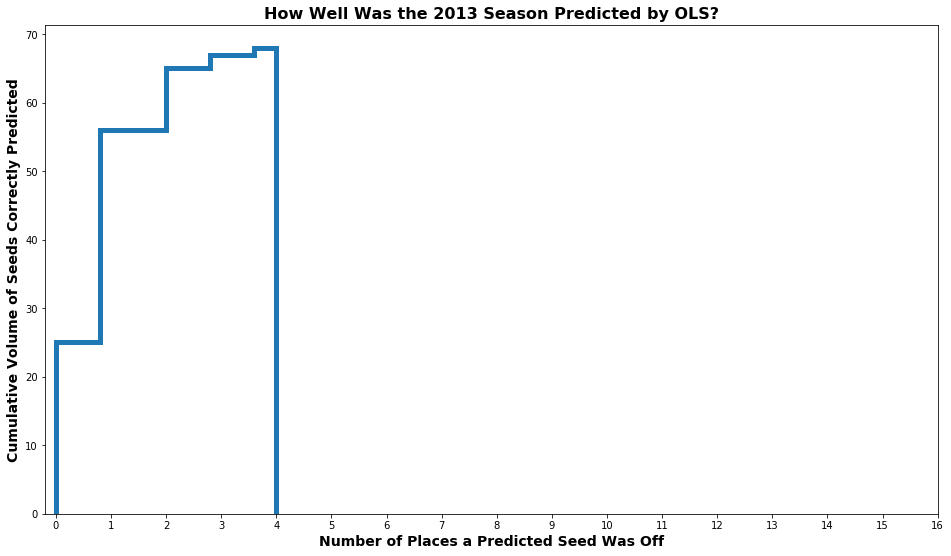

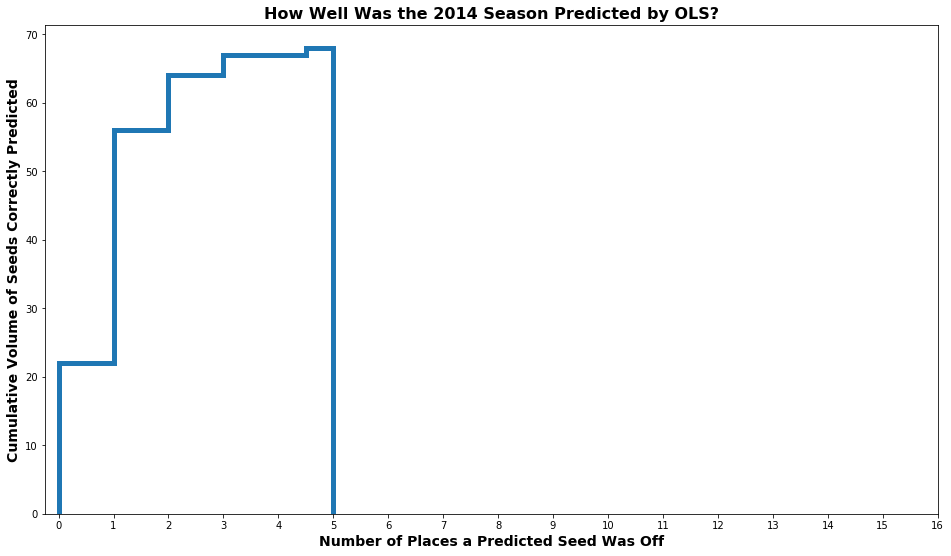

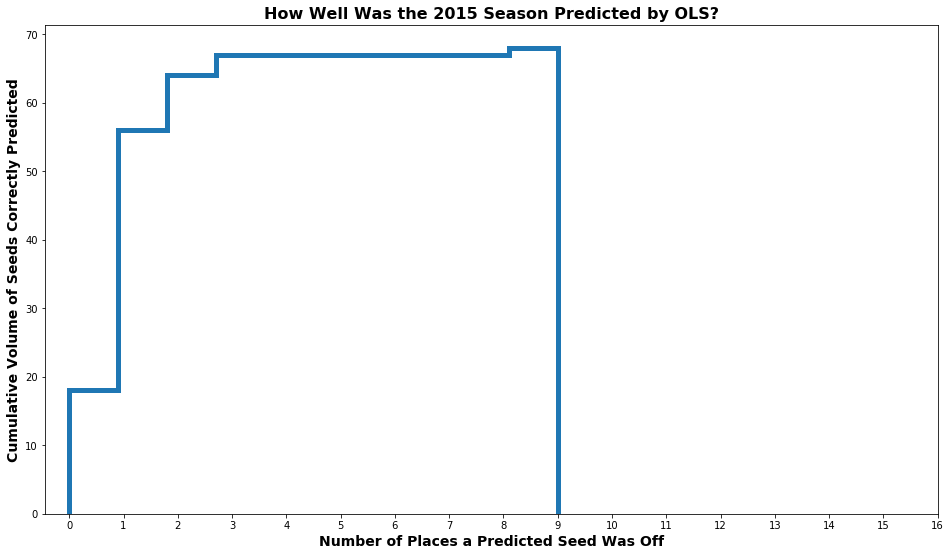

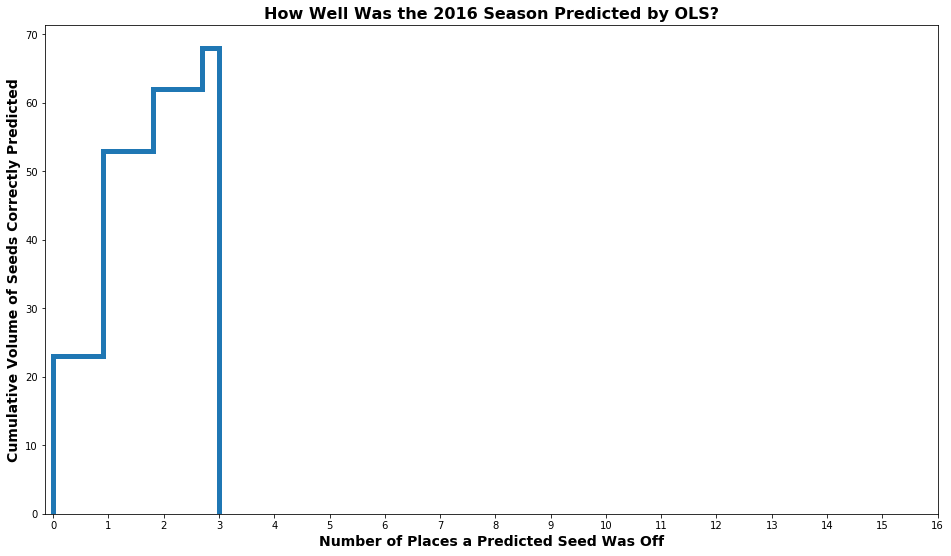

In [20]:
#seedformula = 'seedf ~ Win_Perc + RPI + conf_name + Conf_Win_Perc'
seedformula = 'seedf ~ Win_Perc + Conf_Win_Perc + SOS + NonConf_SOS'

# Initialize regression testing variables
overall_correct = overall_correct_pct = 0
overall_correct_1 = overall_correct_1_pct = 0
nseasons = 0

# Loop through each season, using that season as the test set.
for s in range(2013, 2017) :
    # Set up test and training data sets
    train = alldf[alldf.season != s]
    test  = alldf[alldf.season == s]
    list_set_sizes = False
    if list_set_sizes :
        print('{}: Train: {}, Test: {}'.format(s, len(train), len(test)) )

    # Create and fit the OLS linear model.
    model = smf.ols(formula=seedformula, data=train)
    fitmodel = model.fit()
    list_summary_results = True
    if list_summary_results :
        print(fitmodel.summary())
    
    # Predict the test set.
    pred = fitmodel.predict(test)
    pred.name = 'predicted'
    result = test.join(other=pred, how='left')
    result.sort_values(by = 'predicted', inplace=True)
    result['seedrank'] = ((result['predicted'].rank(axis='index', method='min') - 1) // 4) + 1
    result['delta'] = abs(result.seed.sub(result.seedrank))

    # Initialize per-k (season) variab;es
    correct = correct_1 = sum_delta = max_delta = 0
    nseeds = len(result)
    
    # Loop through each seed, recording result
    for i in range(nseeds) :
    #for i, d in result.iterrows() :
        # What are the acutals and predicted?
        actual_seed = result.iloc[i].seed
        predicted_seed = result.iloc[i].seedrank
        
        # Did we predict correct?
        delta = result.iloc[i].delta
        correct = correct + (1 if delta == 0 else 0)
        correct_1 = correct_1 + (1 if delta == 1 else 0)
        
        # Report the result to screen
        list_team_results = False
        if list_team_results :
            print('{:24} {:18} {:5.0f} {:5.0f} {:6.3f}'.format(
                result.iloc[i].market_seed, 
                result.iloc[i].name_seed,
                actual_seed,
                predicted_seed,
                round(result.iloc[i].predicted, 3)))
    
    # Update the result computations
    nseasons = nseasons + 1
    overall_correct = overall_correct + correct
    overall_correct_1 = overall_correct_1 + correct_1
    
    # Provide reports of the trail (per k)
    report_results_in_text(test_set_id=s, delta = result.delta, nseeds=nseeds, k=4)
    report_results_in_graph(test_set_id=s, delta=result.delta, modeltype='OLS', report_as='values')

# Compute the overall results scores
overall_correct_pct = overall_correct / (nseasons * nseeds)
overall_correct_1_pct = overall_correct_1 / (nseasons * nseeds)

## Save the Results

Save the results of the trial to disk for later comparison of models.

In [14]:
save_results(
    modeltype='OLS', 
    k=4, 
    correctpct=overall_correct_pct, 
    correct1pct=overall_correct_1_pct, 
    specifics=seedformula)

# Model 2: Random Forest Regressor

In [15]:
# Define predictor variables.
Xvars = [
    'points_game', 'rebounds', 'steals', 'blocks', 'assists_turnover_ratio', 'team_rebounds', 'opp_points_game',
    'Win_Perc', 'Conf_Win_Perc', 'Conference_Champ', 'wins', 'losses', 'ties', 'SOS', 'NonConf_SOS', 'RPI']
yvar = ['seed']
refvars = ['seed']

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


------------------------------

RESULTS FOR TEST SET: 2013
     ACCURACY: 23 33.82%;
+/-1 ACCURACY: 33 48.53%;
      ACC SUM: 82.35%;
AVERAGE DELTA:    0.9;
MAXIMUM DELTA:      4;


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


------------------------------

RESULTS FOR TEST SET: 2014
     ACCURACY: 20 29.41%;
+/-1 ACCURACY: 38 55.88%;
      ACC SUM: 85.29%;
AVERAGE DELTA:    1.0;
MAXIMUM DELTA:      5;


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s


------------------------------

RESULTS FOR TEST SET: 2015
     ACCURACY: 20 29.41%;
+/-1 ACCURACY: 35 51.47%;
      ACC SUM: 80.88%;
AVERAGE DELTA:    1.0;
MAXIMUM DELTA:      6;


[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed:    0.0s finished


------------------------------

RESULTS FOR TEST SET: 2016
     ACCURACY: 14 20.59%;
+/-1 ACCURACY: 34 50.00%;
      ACC SUM: 70.59%;
AVERAGE DELTA:    1.3;
MAXIMUM DELTA:      5;


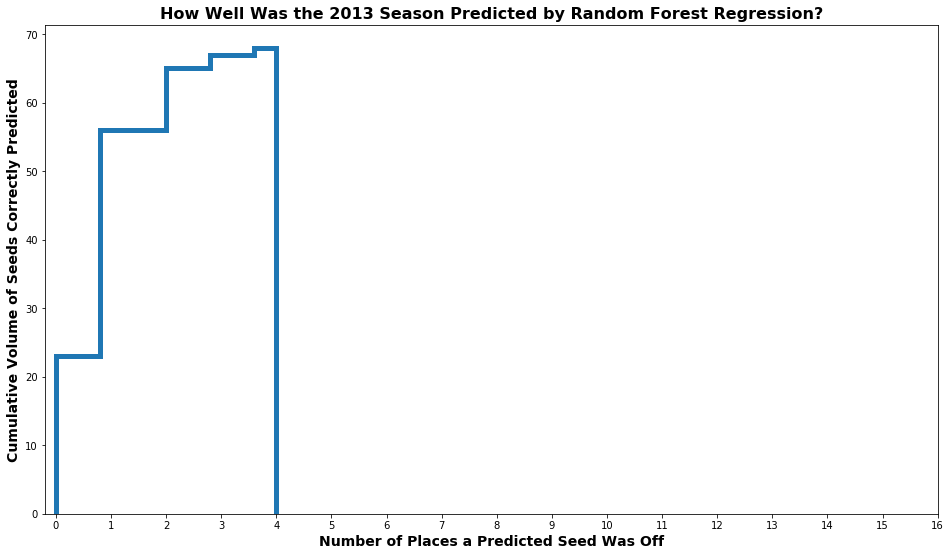

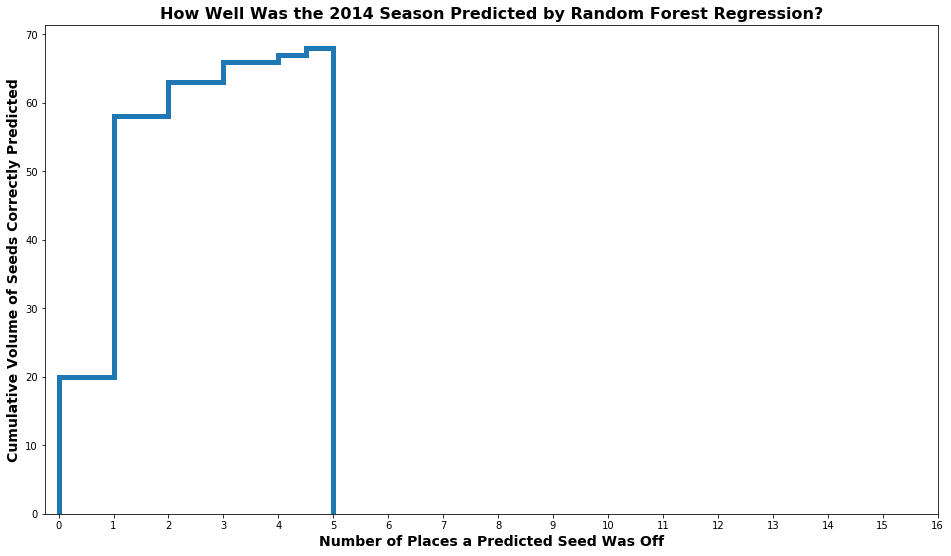

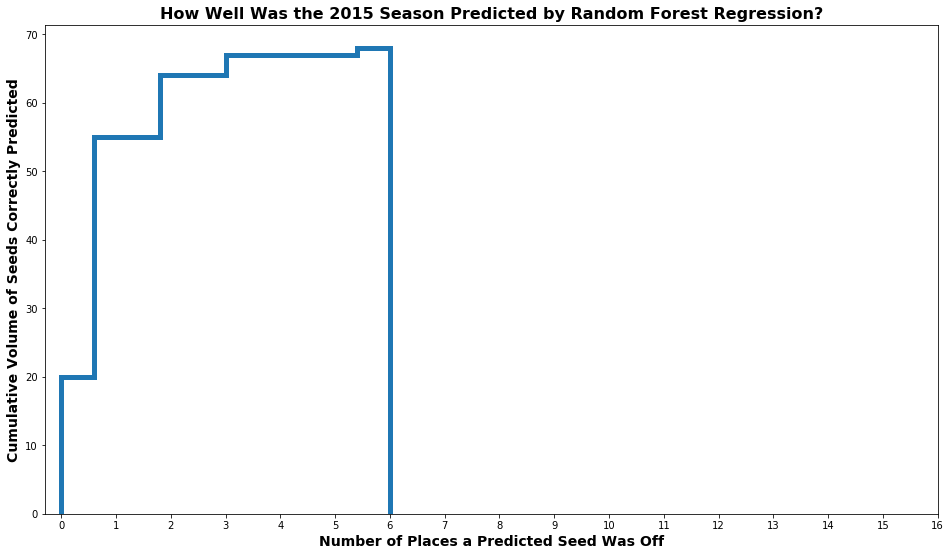

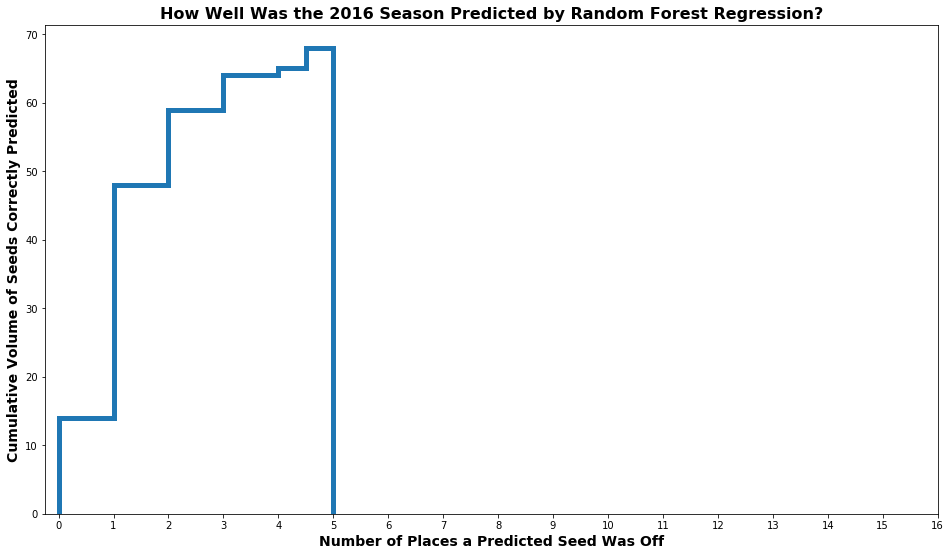

In [16]:
# Initialize variables to record stats
overall_correct = overall_correct_pct = 0
overall_correct_1 = overall_correct_1_pct = 0
nseasons = 0

for s in range(2013, 2017) :
    # Define training set
    train = alldf.loc[alldf.season != s]
    trainX = train.loc[ : , Xvars]
    trainy = np.ravel(train.loc[ : , yvar])
    trainrefs = train.loc[ : , refvars]
    
    # Define the test set
    test = alldf.loc[alldf.season == s]
    testX = test.loc[ : , Xvars]
    testy = np.ravel(test.loc[ : , yvar])
    testrefs = test.loc[ : , refvars]

    rfreg = skle.RandomForestRegressor(
        n_estimators=125, criterion='mse', max_depth=6, min_samples_split=2, min_samples_leaf=1,
        max_leaf_nodes=68, n_jobs=3, random_state=RSEED, verbose=1, warm_start=False)
    params="n_estimators=125, criterion='mse', max_depth=6, min_samples_split=2, min_samples_leaf=1, " + \
        "max_leaf_nodes=68, n_jobs=3, random_state=RSEED, verbose=1, warm_start=False"
    rfreg.fit(trainX, trainy)
    predicted = rfreg.predict(testX)
    score = rfreg.score(testX, testy)
    
    # Create a summary dataset
    result = testX
    result['predicted'] = predicted
    result['seedrank'] = ((result['predicted'].rank(axis='index', method='min') - 1) // 4) + 1
    result['seed'] = testrefs.seed
    result['delta'] = abs(result.seed.sub(result.seedrank))
    sorted_result = result.sort_values(by = 'predicted')
    
    # Review the results
    correct = correct_1 = sum_delta = max_delta = 0
    nseeds = len(result)
    for i in range(nseeds) :
        # What are the acutals and predicted?
        actual_seed = result.iloc[i].seed
        predicted_seed = result.iloc[i].seedrank
        
        # How far off was the prediction?
        delta = result.iloc[i].delta
        sum_delta = sum_delta + delta
        if delta > max_delta :
            max_delta = delta
        
        # Did we predict correct?
        correct = correct + (1 if delta == 0 else 0)
        correct_1 = correct_1 + (1 if delta == 1 else 0)
        
        # Report the result
        list_team_results = False
        if list_team_results :
            print('{:24} {:18} {:5.0f} {:5.0f} {:6.3f}'.format(
                result.iloc[i].market_seed, 
                result.iloc[i].name_seed,
                actual_seed,
                predicted_seed,
                round(result.iloc[i].predicted, 3)))
    
    # Update the result computations
    nseasons = nseasons + 1
    overall_correct = overall_correct + correct
    overall_correct_1 = overall_correct_1 + correct_1

    report_results_in_text(test_set_id=s, delta=result.delta, nseeds=nseeds, k=4)
    report_results_in_graph(
        test_set_id=s, delta=result.delta, modeltype='Random Forest Regression', report_as='values')
    
# Compute the overall results scores
overall_correct_pct = overall_correct / (nseasons * nseeds)
overall_correct_1_pct = overall_correct_1 / (nseasons * nseeds)

## Save the Results

In [17]:
save_results(
    modeltype='Random Forest', 
    k=4, 
    correctpct=overall_correct_pct, 
    correct1pct=overall_correct_1_pct, 
    specifics=params)

# Model 3: Support Vector Machine Regression

In [18]:
# Define predictor variables.
Xvars = [
    'points_game', 'rebounds', 'steals', 'blocks', 'assists_turnover_ratio', 'team_rebounds', 'opp_points_game',
    'Win_Perc', 'Conf_Win_Perc', 'Conference_Champ', 'wins', 'losses', 'ties', 'SOS', 'NonConf_SOS', 'RPI']
yvar = ['seed']
refvars = ['seed']

[LibSVM]------------------------------

RESULTS FOR TEST SET: 2013
     ACCURACY: 13 19.12%;
+/-1 ACCURACY: 23 33.82%;
      ACC SUM: 52.94%;
AVERAGE DELTA:    1.8;
MAXIMUM DELTA:      8;
[LibSVM]------------------------------

RESULTS FOR TEST SET: 2014
     ACCURACY: 17 25.00%;
+/-1 ACCURACY: 22 32.35%;
      ACC SUM: 57.35%;
AVERAGE DELTA:    1.7;
MAXIMUM DELTA:      7;
[LibSVM]------------------------------

RESULTS FOR TEST SET: 2015
     ACCURACY: 15 22.06%;
+/-1 ACCURACY: 28 41.18%;
      ACC SUM: 63.24%;
AVERAGE DELTA:    1.7;
MAXIMUM DELTA:     10;
[LibSVM]------------------------------

RESULTS FOR TEST SET: 2016
     ACCURACY: 12 17.65%;
+/-1 ACCURACY: 30 44.12%;
      ACC SUM: 61.76%;
AVERAGE DELTA:    1.7;
MAXIMUM DELTA:      7;


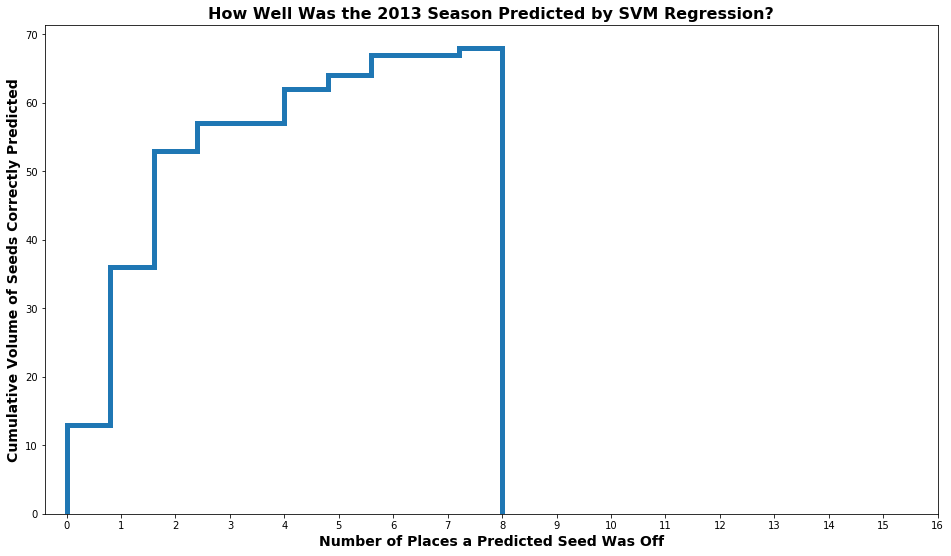

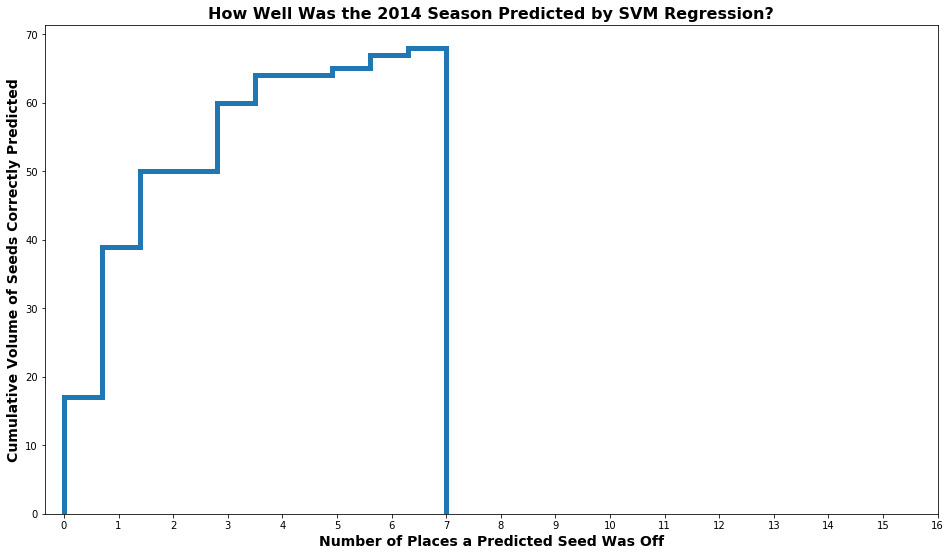

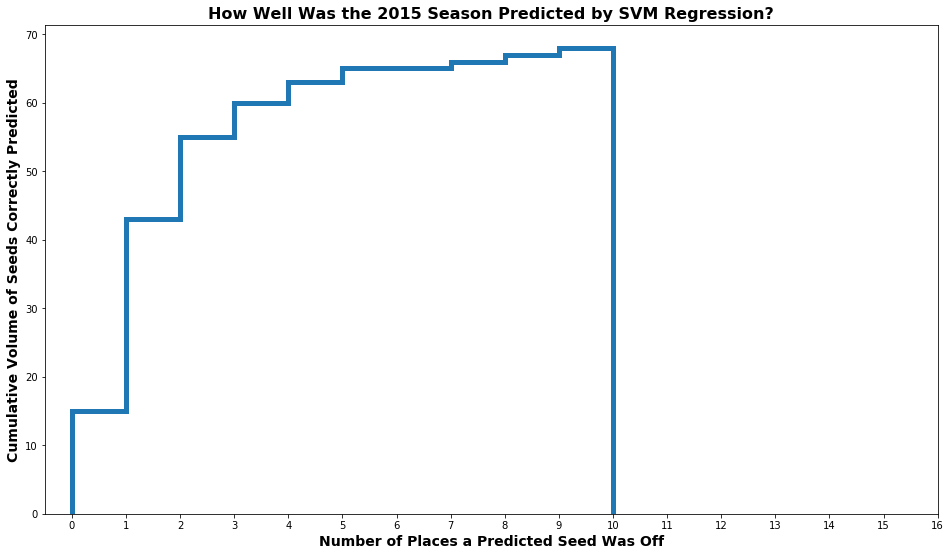

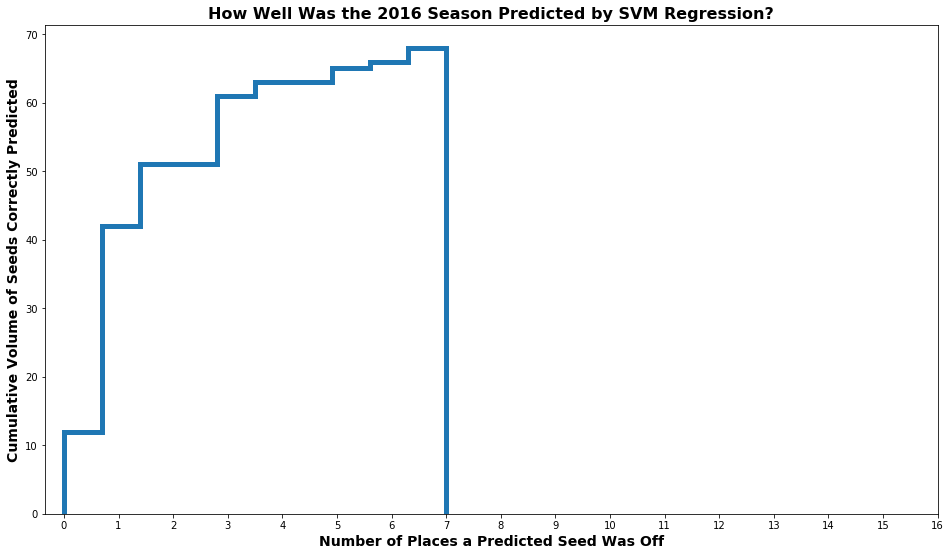

In [19]:
# Initialize variables to record stats
overall_correct = overall_correct_pct = 0
overall_correct_1 = overall_correct_1_pct = 0
nseasons = 0

for s in range(2013, 2017) :
    # Define training set
    train = alldf.loc[alldf.season != s]
    trainX = train.loc[ : , Xvars]
    trainy = np.ravel(train.loc[ : , yvar])
    trainrefs = train.loc[ : , refvars]
    
    # Define the test set
    test = alldf.loc[alldf.season == s]
    testX = test.loc[ : , Xvars]
    testy = np.ravel(test.loc[ : , yvar])
    testrefs = test.loc[ : , refvars]
    
    # Create the support vector regressor
    # `degree` is only used by the poly kernel.
    # `gamma` is only used by rbf, poly and sigmoid kernels.
    # `coef0` is only used by poly and sigmoid kernels.
    svr = sklsvm.SVR(
        kernel='linear', degree=3, gamma='auto', coef0=0.0, tol=1e-3, C=5.0, epsilon=0.1, shrinking=True,
        verbose=True, max_iter=-1)
    params="kernel='rbf', degree=3, gamma='scale', coef0=100.0, tol=1e-3, C=1.0, epsilon=0.1, " + \
        "shrinking=True, verbose=True, maxiter=1000"
    svr.fit(trainX, trainy)
    predicted = svr.predict(testX)
    score = svr.score(testX, testy)
    
    # Create a summary dataset
    result = testX
    result['predicted'] = predicted
    result['seedrank'] = ((result['predicted'].rank(axis='index', method='min') - 1) // 4) + 1
    result['seed'] = testrefs.seed
    result['delta'] = abs(result.seed.sub(result.seedrank))
    sorted_result = result.sort_values(by = 'predicted')
    
    # Review the results
    correct = correct_1 = sum_delta = max_delta = 0
    nseeds = len(result)
    for i in range(nseeds) :
        # What are the acutals and predicted?
        actual_seed = result.iloc[i].seed
        predicted_seed = result.iloc[i].seedrank
        
        # How far off was the prediction?
        delta = result.iloc[i].delta
        sum_delta = sum_delta + delta
        if delta > max_delta :
            max_delta = delta
        
        # Did we predict correct?
        correct = correct + (1 if delta == 0 else 0)
        correct_1 = correct_1 + (1 if delta == 1 else 0)
        
        # Report the result
        list_team_results = False
        if list_team_results :
            print('{:24} {:18} {:5.0f} {:5.0f} {:6.3f}'.format(
                result.iloc[i].market_seed, 
                result.iloc[i].name_seed,
                actual_seed,
                predicted_seed,
                round(result.iloc[i].predicted, 3)))
    
    # Update the result computations
    nseasons = nseasons + 1
    overall_correct = overall_correct + correct
    overall_correct_1 = overall_correct_1 + correct_1

    report_results_in_text(test_set_id=s, delta=result.delta, nseeds=nseeds, k=4)
    report_results_in_graph(test_set_id=s, delta=result.delta, modeltype='SVM Regression', report_as='values')
    
# Compute the overall results scores
overall_correct_pct = overall_correct / (nseasons * nseeds)
overall_correct_1_pct = overall_correct_1 / (nseasons * nseeds)

In [ ]:
save_results(
    modeltype='SVM', 
    k=4, 
    correctpct=overall_correct_pct, 
    correct1pct=overall_correct_1_pct, 
    specifics=params)